In [ ]:
!nvidia-smi

Tue May  7 12:47:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5ir6p05r
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5ir6p05r
  Resolved https://github.com/facebookresearch/detectron2.git to commit 0ae803b1449cd2d3f8fa1b7c0f59356db10b3083
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6147899 sha256=b4a1442a4a6930b736ddf798738de

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# COMMON LIBRARIES
import detectron2
import os
import cv2

from datetime import datetime
from google.colab.patches import cv2_imshow

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

In [ ]:
image = cv2.imread("./1.jpeg")
cv2_imshow(image)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")

predictor = DefaultPredictor(cfg)
outputs = predictor(image)

print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
#all
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="...................")
project = rf.workspace("major-project-ovape").project("dronecapturedimages")
version = project.version(10)
dataset = version.download("coco-segmentation")




loading Roboflow workspace...
loading Roboflow project...


In [ ]:
DATA_SET_NAME = dataset.name.replace(" ", "-")
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

In [ ]:
# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME,
    metadata={},
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH,
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "test")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME,
    metadata={},
    json_file=TEST_DATA_SET_ANN_FILE_PATH,
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME,
    metadata={},
    json_file=VALID_DATA_SET_ANN_FILE_PATH,
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

In [ ]:
[
    data_set
    for data_set
    in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

['DroneCapturedImages-train',
 'DroneCapturedImages-test',
 'DroneCapturedImages-valid']

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



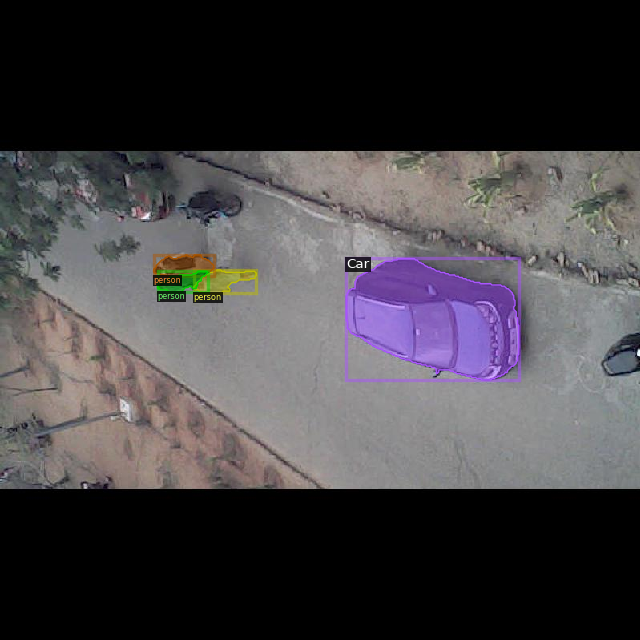

In [ ]:
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[0]
image = cv2.imread(dataset_entry["file_name"])

visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata,
    scale=0.8,
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# HYPERPARAMETERS
ARCHITECTURE = "mask_rcnn_R_101_FPN_3x"
CONFIG_FILE_PATH = f"COCO-InstanceSegmentation/{ARCHITECTURE}.yaml"
MAX_ITER = 15000
EVAL_PERIOD = 200
BASE_LR = 0.001
NUM_CLASSES = 9

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME,
    ARCHITECTURE,
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/14 07:48:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:02, 93.9MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[05/14 07:48:52 d2.engine.train_loop]: Starting training from iteration 0


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)


[05/14 07:49:07 d2.utils.events]:  eta: 1:46:14  iter: 19  total_loss: 4.079  loss_cls: 2.252  loss_box_reg: 0.6384  loss_mask: 0.691  loss_rpn_cls: 0.3306  loss_rpn_loc: 0.1127    time: 0.4396  last_time: 0.5000  data_time: 0.0405  last_data_time: 0.0224   lr: 1.9981e-05  max_mem: 2424M
[05/14 07:49:20 d2.utils.events]:  eta: 1:53:04  iter: 39  total_loss: 3.702  loss_cls: 1.905  loss_box_reg: 0.7491  loss_mask: 0.6851  loss_rpn_cls: 0.1676  loss_rpn_loc: 0.07883    time: 0.4543  last_time: 0.5038  data_time: 0.0198  last_data_time: 0.0160   lr: 3.9961e-05  max_mem: 2545M
[05/14 07:49:31 d2.utils.events]:  eta: 1:56:44  iter: 59  total_loss: 3.02  loss_cls: 1.456  loss_box_reg: 0.7313  loss_mask: 0.6789  loss_rpn_cls: 0.1317  loss_rpn_loc: 0.08682    time: 0.4805  last_time: 0.4563  data_time: 0.0506  last_data_time: 0.0100   lr: 5.9941e-05  max_mem: 2862M
[05/14 07:49:41 d2.utils.events]:  eta: 1:56:55  iter: 79  total_loss: 2.679  loss_cls: 1.037  loss_box_reg: 0.811  loss_mask: 0.6

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir $OUTPUT_DIR_PATH

In [ ]:
import json
from torch.utils.tensorboard import SummaryWriter

# Load metrics data from JSON file
with open('/content/drive/MyDrive/@@MAJPROFINALCODES@@/Stored Training Model/metrics1.json', 'r') as f:
    metrics_data = json.load(f)


if isinstance(metrics_data, list):
    # Assuming the list contains dictionaries, you can merge them into a single dictionary
    merged_metrics = {}
    for d in metrics_data:
        for key, value in d.items():
            if key in merged_metrics:
                # If the key already exists, append the value to a list
                merged_metrics[key].append(value)
            else:
                # Otherwise, create a new list with the value
                merged_metrics[key] = [value]
    # Convert lists to single values if there's only one item per key
    for key, value in merged_metrics.items():
        if len(value) == 1:
            merged_metrics[key] = value[0]
    metrics_data = merged_metrics



In [ ]:
data=metrics_data
print(data)

{'data_time': [0.016019114999949124, 0.018200269499971, 0.021210157500036075, 0.018970195000008516, 0.017172575000017787, 0.02387706049995586, 0.02558349499997803, 0.017045139000003928, 0.02300027449996378, 0.022555788999966353, 0.018489160500053003, 0.022733712999979616, 0.022657567000010204, 0.023323220500003572, 0.012692463500059148, 0.024042682000015247, 0.019259634499974254, 0.01631040600000233, 0.02200563800005284, 0.02305097549998436, 0.024016587500057085, 0.019859504500004732, 0.01740899349999836, 0.01675636499993516, 0.018752449999965393, 0.022271207999892795, 0.023190865000060512, 0.02145146299994849, 0.018920904500077995, 0.016569611500017345, 0.02129714950001471, 0.01686965149997377, 0.01651295249996565, 0.023003692999964187, 0.021262670500050262, 0.017911088999994718, 0.022692742500112217, 0.02086541500000294, 0.019895936500006428, 0.014794030499956534, 0.024858866000045055, 0.020095106000098895, 0.016385577000050944, 0.02002120750000813, 0.021612561999972968, 0.0209868915

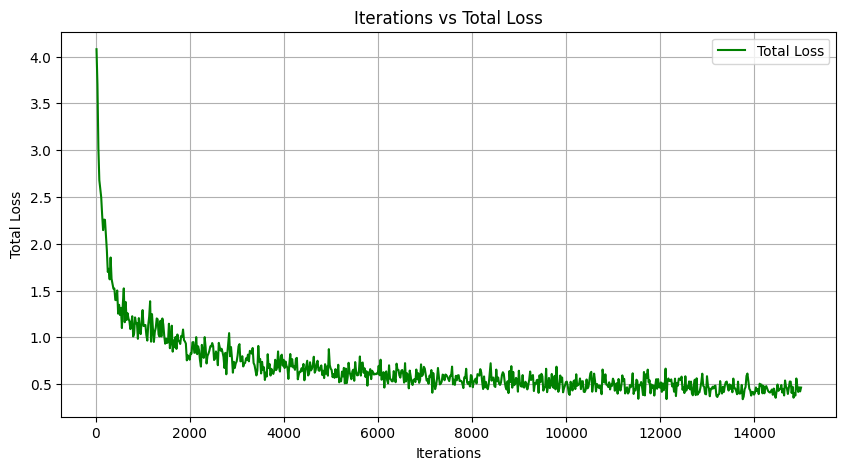

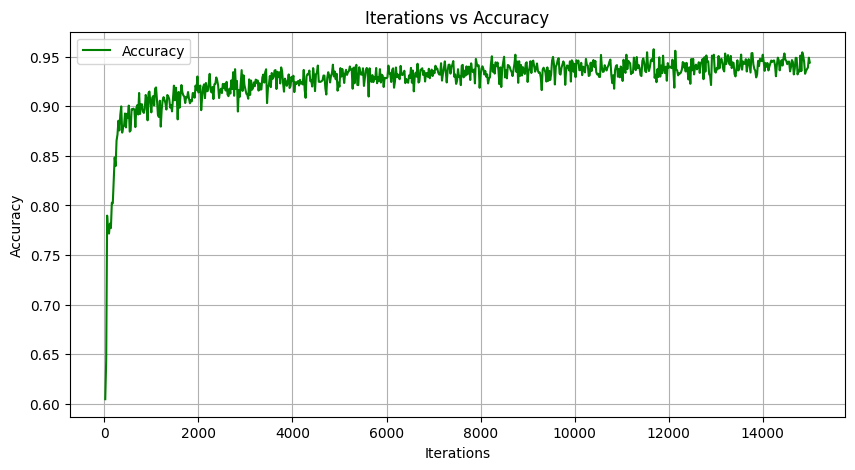

In [ ]:
import matplotlib.pyplot as plt
import mplcursors

# Extract data for plotting
iterations = data['iteration']
total_loss = data['total_loss']
accuracy = data['mask_rcnn/accuracy']

# Plotting the graph between iterations and total loss
plt.figure(figsize=(10, 5))
plt.plot(iterations, total_loss, label='Total Loss', color='green')
plt.xlabel('Iterations')
plt.ylabel('Total Loss')
plt.title('Iterations vs Total Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the graph between iterations and accuracy
plt.figure(figsize=(10, 5))
plt.plot(iterations, accuracy, label='Accuracy', color='green')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Iterations vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

[05/13 06:36:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from DroneCapturedImages/mask_rcnn_R_101_FPN_3x/2024-05-13-05-06-40/model_final.pth ...


In [ ]:
dataset_valid = DatasetCatalog.get(VALID_DATA_SET_NAME)

for d in dataset_valid:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
predictor = DefaultPredictor(cfg)



image = cv2.imread("aerial-view-motorcycles-parking-row-aerial-view-motorcycles-parking-row-concrete-floor-background-use-118417696 (1).jpg")
cv2_imshow(image)
outputs = predictor(image)

print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Initialize dictionary to count individual objects
object_counts = {}

# Iterate through instances
for i in range(len(outputs["instances"])):
    class_id = outputs["instances"].pred_classes[i].item()
    class_name = metadata.thing_classes[class_id]
    if class_name not in object_counts:
        object_counts[class_name] = 0
    object_counts[class_name] += 1

# Display counts of individual objects
for class_name, count in object_counts.items():
    print(f"Number of {class_name}: {count}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
predictor = DefaultPredictor(cfg)



image = cv2.imread("./5a6f714b7ffc16e3967d450e66162e30.jpg")
cv2_imshow(image)
outputs = predictor(image)

print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Initialize dictionary to count individual objects
object_counts = {}

# Iterate through instances
for i in range(len(outputs["instances"])):
    class_id = outputs["instances"].pred_classes[i].item()
    class_name = metadata.thing_classes[class_id]
    if class_name not in object_counts:
        object_counts[class_name] = 0
    object_counts[class_name] += 1

# Display counts of individual objects
for class_name, count in object_counts.items():
    print(f"Number of {class_name}: {count}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
predictor = DefaultPredictor(cfg)



image = cv2.imread("48.jpg")
cv2_imshow(image)
outputs = predictor(image)

print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Initialize dictionary to count individual objects
object_counts = {}

# Iterate through instances
for i in range(len(outputs["instances"])):
    class_id = outputs["instances"].pred_classes[i].item()
    class_name = metadata.thing_classes[class_id]
    if class_name not in object_counts:
        object_counts[class_name] = 0
    object_counts[class_name] += 1

# Display counts of individual objects
for class_name, count in object_counts.items():
    print(f"Number of {class_name}: {count}")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
predictor = DefaultPredictor(cfg)



image = cv2.imread("47.jpg")
cv2_imshow(image)
outputs = predictor(image)

print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Initialize dictionary to count individual objects
object_counts = {}

# Iterate through instances
for i in range(len(outputs["instances"])):
    class_id = outputs["instances"].pred_classes[i].item()
    class_name = metadata.thing_classes[class_id]
    if class_name not in object_counts:
        object_counts[class_name] = 0
    object_counts[class_name] += 1

# Display counts of individual objects
for class_name, count in object_counts.items():
    print(f"Number of {class_name}: {count}")


Output hidden; open in https://colab.research.google.com to view.

[05/13 06:51:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from DroneCapturedImages/mask_rcnn_R_101_FPN_3x/2024-05-13-05-06-40/model_final.pth ...


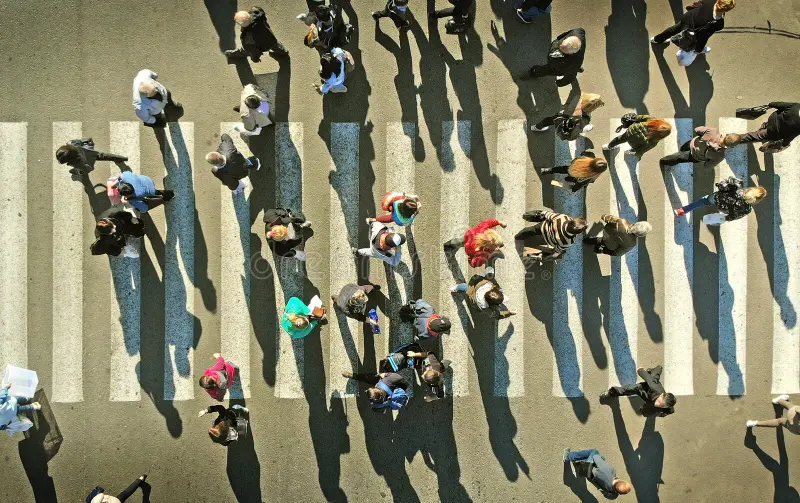

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       device='cuda:0')
Boxes(tensor([[2.8148e+02, 2.9555e+02, 3.2561e+02, 3.3772e+02],
        [3.6716e+02, 1.9135e+02, 4.2048e+02, 2.2508e+02],
        [1.0664e+02, 1.7189e+02, 1.7241e+02, 2.1308e+02],
        [1.3262e+02, 6.7598e+01, 1.8103e+02, 1.2598e+02],
        [5.8669e+02, 2.1460e+02, 6.4474e+02, 2.5528e+02],
        [3.1577e+02, 4.7445e+01, 3.5186e+02, 9.3665e+01],
        [5.2749e+02, 2.7120e+01, 5.8551e+02, 9.6191e+01],
        [6.5311e+02, 0.0000e+00, 7.3402e+02, 6.5531e+01],
        [5.1533e+02, 2.0948e+02, 5.8745e+02, 2.6526e+02],
        [9.1979e+01, 2.0812e+02, 1.4578e+02, 2.5400e+02],
        [6.0270e+02, 3.6573e+02, 6.7566e+02, 4.1293e+02],
        [3.5634e+02, 2.2696e+02, 4.0279e+02, 2.6247e+02],
        [2.6520e+02, 2.0891e+02, 3.1332e+02, 2.5779e+02],
        [2.2626e+02, 5.7504e+00, 2.8736e+02, 6.7557e+01],
   

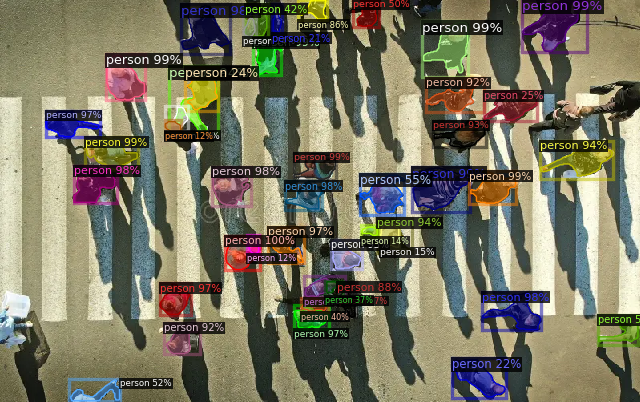

Number of person: 46


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
predictor = DefaultPredictor(cfg)



image = cv2.imread("46.jpg")
cv2_imshow(image)
outputs = predictor(image)

print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Initialize dictionary to count individual objects
object_counts = {}

# Iterate through instances
for i in range(len(outputs["instances"])):
    class_id = outputs["instances"].pred_classes[i].item()
    class_name = metadata.thing_classes[class_id]
    if class_name not in object_counts:
        object_counts[class_name] = 0
    object_counts[class_name] += 1

# Display counts of individual objects
for class_name, count in object_counts.items():
    print(f"Number of {class_name}: {count}")


[05/13 07:06:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/FINALMAJORPROJECT_OUTPUTS/DroneCapturedImages/mask_rcnn_R_101_FPN_3x/2024-05-13-05-06-40/model_final.pth ...


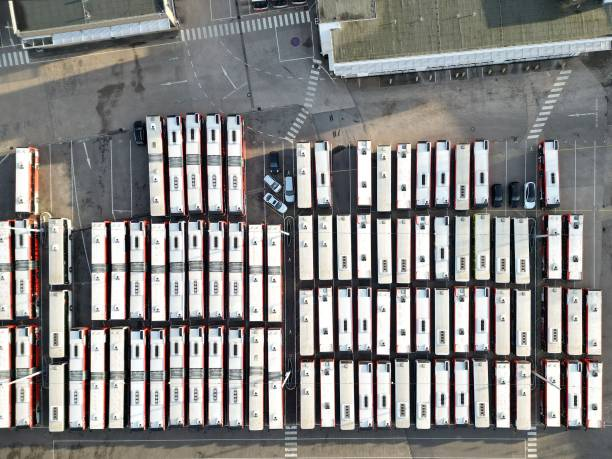

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3],
       device='cuda:0')
Boxes(tensor([[566.9365, 361.0887, 581.6176, 428.3174],
        [358.0172, 143.8229, 371.1158, 207.6566],
        [296.9372, 144.1021, 311.1242, 209.0601],
        [543.5328, 138.7344, 559.1879, 206.3660],
        [455.5127, 143.7495, 469.5324, 209.1125],
        [315.4036, 142.3824, 330.5346, 207.4631],
        [473.8952, 141.8141, 487.9628, 206.6792],
        [544.2706, 360.2483, 560.5632, 427.5623],
        [435.7232, 141.8037, 449.9539, 205.6093],
        [207.5740, 327.0386, 222.9707, 427.3773],
        [475.1297, 287.6818, 489.0797, 352.2206],
        [496.5627, 363.0890, 510.2584, 427.7404],
        [416.7520, 142.3262, 430.5305, 206.7944],
        [473.6

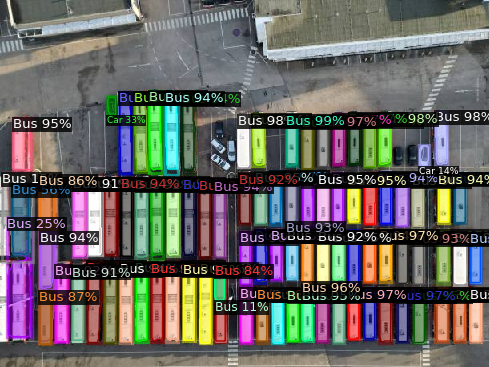

Number of Bus: 89
Number of Car: 2


In [ ]:
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/FINALMAJORPROJECT_OUTPUTS/DroneCapturedImages/mask_rcnn_R_101_FPN_3x/2024-05-13-05-06-40/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
predictor = DefaultPredictor(cfg)



image = cv2.imread("gettyimages-1979709809-612x612.jpg")
cv2_imshow(image)
outputs = predictor(image)

print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Initialize dictionary to count individual objects
object_counts = {}

# Iterate through instances
for i in range(len(outputs["instances"])):
    class_id = outputs["instances"].pred_classes[i].item()
    class_name = metadata.thing_classes[class_id]
    if class_name not in object_counts:
        object_counts[class_name] = 0
    object_counts[class_name] += 1

# Display counts of individual objects
for class_name, count in object_counts.items():
    print(f"Number of {class_name}: {count}")


# Storing the model,config,metadata files

In [ ]:
# Save the trained model and configuration
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

# Save the model and configuration
torch.save(predictor.model.state_dict(), "/content/drive/MyDrive/@@MAJPROFINALCODES@@/Stored Training Model/model.pth")
with open("/content/drive/MyDrive/@@MAJPROFINALCODES@@/Stored Training Model/config.yaml", "w") as f:
    f.write(cfg.dump())


[05/14 10:02:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from DroneCapturedImages/mask_rcnn_R_101_FPN_3x/2024-05-14-07-48-37/model_final.pth ...


In [ ]:
print(metadata)

Metadata(name='DroneCapturedImages-train', json_file='/content/DroneCapturedImages-10/train/_annotations.coco.json', image_root='/content/DroneCapturedImages-10/train', evaluator_type='coco', thing_classes=['Buildings', 'Auto', 'Building', 'Bus', 'Car', 'Motorcycle', 'Truck', 'Van', 'person'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8})


In [ ]:
import json

metadata_dict = {
    "name": "DroneCapturedImages-train",
    "json_file": "/content/DroneCapturedImages-10/train/_annotations.coco.json",
    "image_root": "/content/DroneCapturedImages-10/train",
    "evaluator_type": "coco",
    "thing_classes": ['Buildings', 'Auto', 'Building', 'Bus', 'Car', 'Motorcycle', 'Truck', 'Van', 'person'],
    "thing_dataset_id_to_contiguous_id": {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}
}

# Save metadata to a JSON file
with open("metadata.json", "w") as json_file:
    json.dump(metadata_dict, json_file)


# Detections

In [ ]:
# Load the saved model and configuration
# model_path = "/content/drive/MyDrive/@@MAJPROFINALCODES@@/Stored Training Model/model.pth"
model_path = "/content/drive/MyDrive/@@MAJPROFINALCODES@@/Stored Training Model/DroneCapturedImages/mask_rcnn_R_101_FPN_3x/2024-05-14-07-48-37/model_0014999.pth"
config_path = "/content/drive/MyDrive/@@MAJPROFINALCODES@@/Stored Training Model/config.yaml"

cfg = get_cfg()
cfg.merge_from_file(config_path)
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # Set the testing threshold for this model

predictor = DefaultPredictor(cfg)


In [ ]:
metadata = {
    "name": "DroneCapturedImages-train",
    "json_file": "/content/DroneCapturedImages-10/train/_annotations.coco.json",
    "image_root": "/content/DroneCapturedImages-10/train",
    "evaluator_type": "coco",
    "thing_classes": ['Buildings', 'Auto', 'Building', 'Bus', 'Car', 'Motorcycle', 'Truck', 'Van', 'person'],
    "thing_dataset_id_to_contiguous_id": {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}
}

In [ ]:

from google.colab.patches import cv2_imshow
image = cv2.imread("46.jpg")
cv2_imshow(image)
outputs = predictor(image)

print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Initialize dictionary to count individual objects
object_counts = {}

# Iterate through instances
for i in range(len(outputs["instances"])):
    class_id = outputs["instances"].pred_classes[i].item()
    class_name = metadata["thing_classes"][class_id]
    if class_name not in object_counts:
        object_counts[class_name] = 0
    object_counts[class_name] += 1

# Display counts of individual objects
for class_name, count in object_counts.items():
    print(f"Number of {class_name}: {count}")


Output hidden; open in https://colab.research.google.com to view.

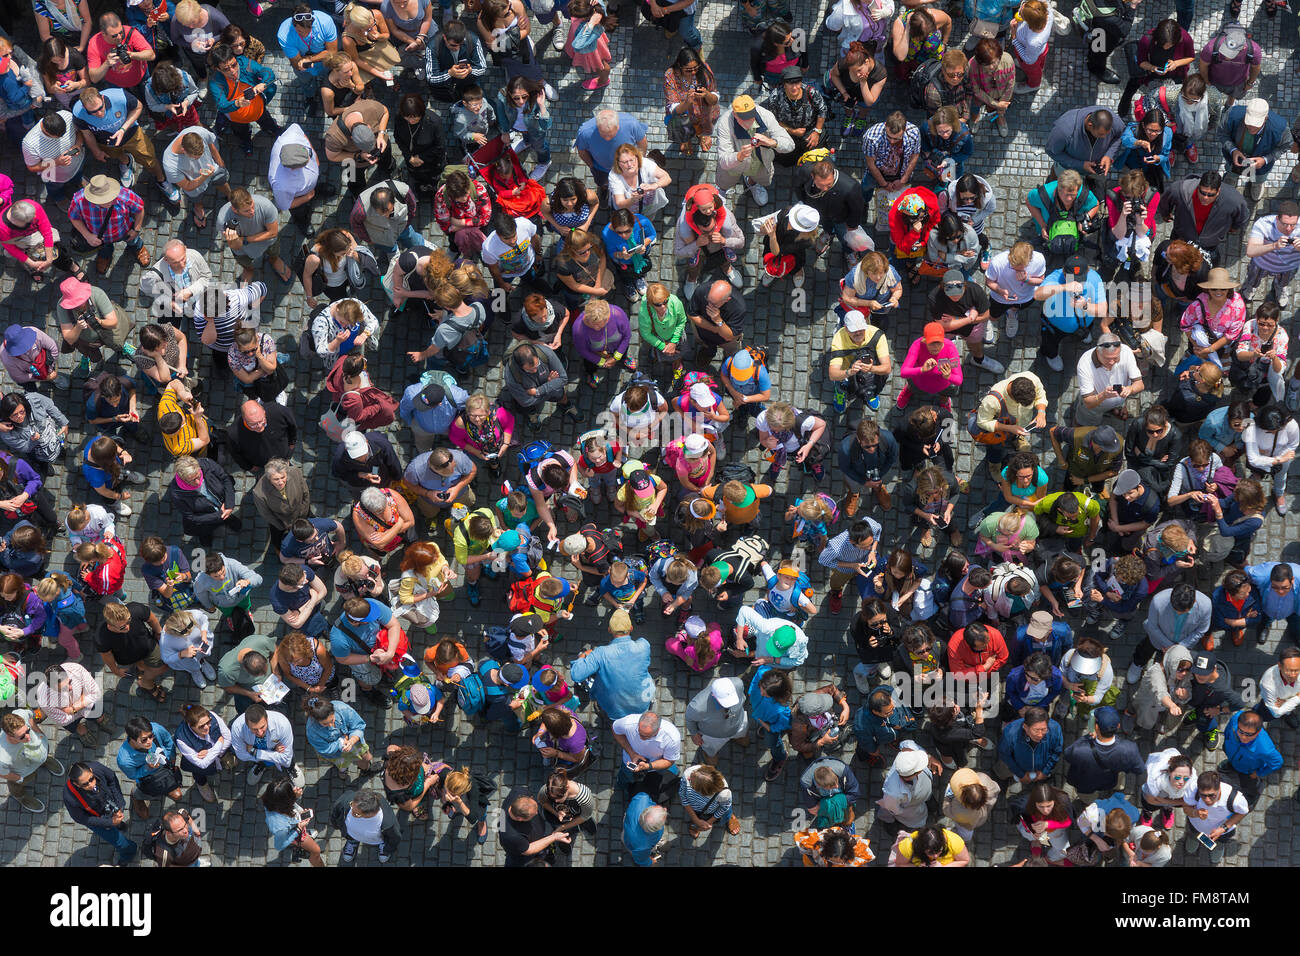

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0')
Boxes(tensor([[4.9926e+02, 7.9103e+02, 5.6270e+02, 8.6404e+02],
        [6.7245e+02, 7.6309e+02, 7.3463e+02, 8.4068e+02],
        [6.0592e+02, 1.4423e+02, 6.6576e+02, 2.1964e+02],
        [1.5673e+02, 6.0659e+02, 2.1496e+02, 6.8799e+02],
        [5.7130e+02, 6.0387e+02, 6.5099e+02, 7.2634e+02],

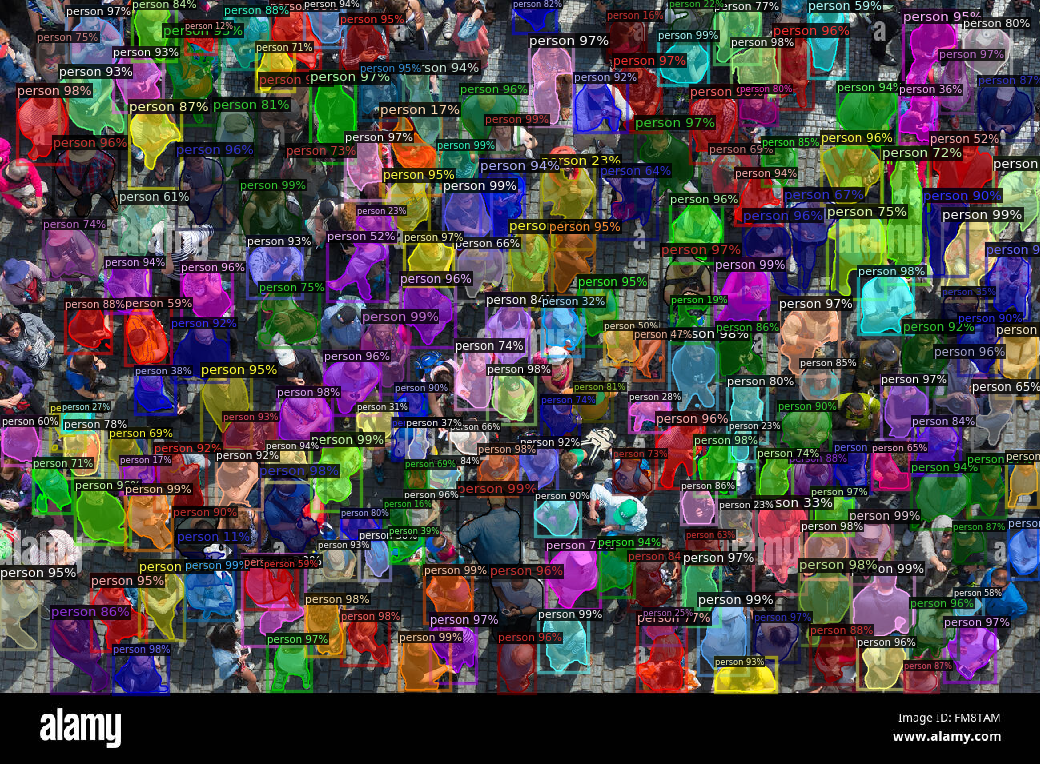

Number of person: 205


In [ ]:
from google.colab.patches import cv2_imshow
image = cv2.imread("48.jpg")
cv2_imshow(image)
outputs = predictor(image)

# Define the class ID you want to filter
target_class_id = 8  # Modify this with the class ID you want to filter

# Initialize dictionary to count individual objects
object_counts = {}

# Iterate through instances
for i in range(len(outputs["instances"])):
    class_id = outputs["instances"].pred_classes[i].item()
    if class_id == target_class_id:
        class_name = metadata.thing_classes[class_id]
        if class_name not in object_counts:
            object_counts[class_name] = 0
        object_counts[class_name] += 1

print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Display counts of individual objects
for class_name, count in object_counts.items():
    print(f"Number of {class_name}: {count}")
